* [x] Make it runable
* [x] Check the issue of the order of marices

In [1]:
%matplotlib inline

import numpy as np
import pylab as pl
import subprocess as sp

import cfuncs as cf
import inps as inp

In [2]:
def convert_one_from_dir(file_name_base, snapid):

    zl_array = np.fromfile(file_name_base+str(snapid)+"/"+"redshift."+str(snapid)+".bin", dtype = "f")
    zl_median = np.median(zl_array)
    mp_array = zl_array*0.0+inp.mpp
    #----------------------------
    xo1 = np.fromfile(file_name_base+str(snapid)+"/"+"theta."+snapid+".bin",dtype = "f")
    xc1 = (xo1.max()+xo1.min())*0.5
    x1_array = (xo1-xc1)*cf.Dc(zl_array)/cf.apr

    xo2 = np.fromfile(file_name_base+str(snapid)+"/"+"phi."+snapid+".bin",dtype = "f")
    xc2 = (xo2.max()+xo2.min())*0.5
    x2_array = (xo2-xc2)*cf.Dc(zl_array)/cf.apr

    xo3 = cf.Dc(zl_array)
    xc3 = (xo3.max()+xo3.min())*0.5
    x3_array = xo3 - xc3

    # #----------------------------
    # xo1 = np.fromfile(file_name_base+str(snapid)+"/"+"x."+snapid+".bin",dtype = ">f")
    # xo2 = np.fromfile(file_name_base+str(snapid)+"/"+"y."+snapid+".bin",dtype = ">f")
    # xo3 = np.fromfile(file_name_base+str(snapid)+"/"+"z."+snapid+".bin",dtype = ">f")
    # xpol3, xpol1, xpol2 =  cart2pol3d(xo1, xo2, xo3)

    # x1_array = np.rad2deg((xpol1 - (xpol1.max()+xpol1.min())*0.5))*3600.*cf.Dc(zl)/cf.apr
    # x2_array = np.rad2deg((xpol2 - (xpol2.max()+xpol2.min())*0.5))*3600.*cf.Dc(zl)/cf.apr
    # x3_array =  xpol3 - (xpol3.max()+xpol3.min())*0.5
    #----------------------------
    zs = inp.zs0
    ncc = inp.nnn
    bsz_mpc = inp.bsz_arc*cf.Dc(zl_median)/cf.apr
    dsx_mpc = bsz_mpc/ncc

    idx1 = x1_array > -0.5*bsz_mpc
    idx2 = x1_array <= 0.5*bsz_mpc
    idx3 = x2_array > -0.5*bsz_mpc
    idx4 = x2_array <= 0.5*bsz_mpc

    idx = idx1&idx2&idx3&idx4

    x1in = x1_array[idx]
    x2in = x2_array[idx]
    x3in = x3_array[idx]
    mpin = mp_array[idx]

    npp = len(mpin)
    if npp < 200:
        return 1

    sdens_cmpch = cf.call_sph_sdens_weight_omp(x1in,x2in,x3in,mpin,bsz_mpc,ncc)

    file_out_sdens =  inp.sdens_path+str(snapid)+"_"+'%.6f'%(zl_median)+"_sdens.bin"
    sdens_cmpch.astype(np.float32).tofile(file_out_sdens)

    kappa = sdens_cmpch*(1.0+zl_median)**2.0/cf.sigma_crit(zl_median,zs)
    #----------------------------
    print snapid, zl_median, zs, np.max(kappa)
    print "Mass 0 = ", np.sum(mpin), np.sum(mp_array)
    print "Mass 1 = ", np.sum(sdens_cmpch)*dsx_mpc*dsx_mpc
    print "-------------------------------"

    file_out_kappa =  inp.kappa_path+str(snapid)+"_"+'%.6f'%(zl_median)+"_"+'%.6f'%(zs)+"_kappa0.bin"
    kappa.astype(np.float32).tofile(file_out_kappa)

    #---------------------------------------
    # Calculate deflection maps
    #
    if snapid == '382':
        BoundaryCondition = "Isolated"
    else:
        BoundaryCondition = "Periodic"

    BoundaryCondition = "Isolated"
#     BoundaryCondition = "Periodic"

    if BoundaryCondition == "Periodic":
        # if mean(mass) ~ mean(Universe)
        alpha1, alpha2 = cf.call_kappa0_to_alphas_p(kappa, inp.bsz_arc, inp.nnn)
    elif BoundaryCondition == "Isolated":
        # if mean(mass) >> mean(Universe)
        alpha1, alpha2 = cf.call_kappa0_to_alphas(kappa, inp.bsz_arc, inp.nnn)
    else:
        print("You should define the Boundary Condition first!!!")

    file_alpha1_out = inp.alpha_path+snapid+"_"+'%.6f'%(zl_median)+"_"+'%.6f'%(zs)+"_alpha1.bin"
    alpha1.astype("float32").tofile(file_alpha1_out)

    file_alpha2_out = inp.alpha_path+snapid+"_"+'%.6f'%(zl_median)+"_"+'%.6f'%(zs)+"_alpha2.bin"
    alpha2.astype("float32").tofile(file_alpha2_out)

    #---------------------------------------
    # Calculate magnification maps
    #
    al11, al12 = np.gradient(alpha1, inp.dsx_arc)
    al21, al22 = np.gradient(alpha2, inp.dsx_arc)
    mua = 1.0/(1.0 - (al11 + al22) + al11*al22 - al12*al21)

    file_mu_out = inp.mu_path+snapid+"_"+'%.6f'%(zl_median)+"_"+'%.6f'%(zs)+"_mu.bin"
    mua.astype("float32").tofile(file_mu_out)

    #---------------------------------------
    # Calculate shear maps
    #
    shear1 = 0.5*(al11 - al22)
    shear2 = 0.5*(al12 + al21)

    file_shear1_out = inp.shear_path+snapid+"_"+'%.6f'%(zl_median)+"_"+'%.6f'%(zs)+"_shear1.bin"
    shear1.astype("float32").tofile(file_shear1_out)

    file_shear2_out = inp.shear_path+snapid+"_"+'%.6f'%(zl_median)+"_"+'%.6f'%(zs)+"_shear2.bin"
    shear2.astype("float32").tofile(file_shear2_out)

    return snapid, zl_median, zs, kappa, alpha1, alpha2, shear1, shear2

def main_create_grid_maps():
    nslices = len(inp.snapid_list)
    for i in xrange(nslices): # the cluster is in '382'?
        print i
        ouput_ar = convert_one_from_dir(inp.input_prtcls_dir+"lcCutout", 
                                        inp.snapid_list[i])
    return 0

In [11]:
def loadin_lens_data_zs0():

    ncc = inp.nnn
    
    cmd1 = "ls " + inp.alpha_path + " | grep alpha1"
    input_alpha1=sp.check_output(cmd1,shell=True)
    fal1_array = input_alpha1.split("\n")[:-1]

    cmd2 = "ls " + inp.alpha_path + " | grep alpha2"
    input_alpha2=sp.check_output(cmd2,shell=True)
    fal2_array = input_alpha2.split("\n")[:-1]

    cmd3 = "ls " + inp.kappa_path + " | grep kappa"
    input_kappas=sp.check_output(cmd3,shell=True)
    fkp0_array = input_kappas.split("\n")[:-1]

    cmd4 = "ls " + inp.shear_path + " | grep shear1"
    input_shear1=sp.check_output(cmd4,shell=True)
    fsh1_array = input_shear1.split("\n")[:-1]

    cmd5 = "ls " + inp.shear_path + " | grep shear2"
    input_shear2=sp.check_output(cmd5,shell=True)
    fsh2_array = input_shear2.split("\n")[:-1]

    nlpz = len(fkp0_array)
    zl_array_tmp = np.zeros((nlpz))

    alpha1_array_tmp = np.zeros((nlpz,ncc,ncc))
    alpha2_array_tmp = np.zeros((nlpz,ncc,ncc))
    kappa0_array_tmp = np.zeros((nlpz,ncc,ncc))
    shear1_array_tmp = np.zeros((nlpz,ncc,ncc))
    shear2_array_tmp = np.zeros((nlpz,ncc,ncc))

    # zs0 = np.float32(fal1_array[0].split("_")[3])

    for i in xrange(nlpz):
        zl_array_tmp[i] = np.float32(fal1_array[i].split("_")[1])

        alpha1_array_tmp[i] = np.fromfile(inp.alpha_path+fal1_array[i],dtype=np.float32).reshape((ncc,ncc))
        alpha2_array_tmp[i] = np.fromfile(inp.alpha_path+fal2_array[i],dtype=np.float32).reshape((ncc,ncc))
        kappa0_array_tmp[i] = np.fromfile(inp.kappa_path+fkp0_array[i],dtype=np.float32).reshape((ncc,ncc))
        shear1_array_tmp[i] = np.fromfile(inp.shear_path+fsh1_array[i],dtype=np.float32).reshape((ncc,ncc))
        shear2_array_tmp[i] = np.fromfile(inp.shear_path+fsh2_array[i],dtype=np.float32).reshape((ncc,ncc))

    idx = np.argsort(zl_array_tmp)
    zl_array_zs0 = zl_array_tmp[idx]
    alpha1_array_zs0 = alpha1_array_tmp[idx]
    alpha2_array_zs0 = alpha2_array_tmp[idx]
    kappa0_array_zs0 = kappa0_array_tmp[idx]
    shear1_array_zs0 = shear1_array_tmp[idx]
    shear2_array_zs0 = shear2_array_tmp[idx]
    
#     for i in xrange(len(zl_array_zs0)):
#         pl.figure()
#         pl.imshow(np.sqrt(shear1_array_zs0[i]**2 + shear2_array_zs0[i]**2))

    return alpha1_array_zs0, alpha2_array_zs0, \
           kappa0_array_zs0, shear1_array_zs0, shear2_array_zs0, \
           zl_array_zs0

In [4]:
from astropy.table import Table

def main_create_grid_maps_hdf5():
    data = Table()
    
    nslices = len(inp.snapid_list)
    
    snapid_ar = []
    zl_ar = []
    zs_ar = []
    kappa0_ar = []
    alpha1_ar = []
    alpha2_ar = []
    shear1_ar = []
    shear2_ar = []
    
#     snapid, zl_median, zs, kappa, alpha1, alpha2, shear1, shear2
    for i in xrange(nslices): # the cluster is in '382'
        output_ar = convert_one_from_dir(inp.input_prtcls_dir+"lcCutout", 
                                         inp.snapid_list[i])
    
        if output_ar == 1:
            continue
        else:
            snapid_ar.append(output_ar[0])
            zl_ar.append(output_ar[1])
            zs_ar.append(output_ar[2])
            kappa0_ar.append(output_ar[3])
            alpha1_ar.append(output_ar[4])
            alpha2_ar.append(output_ar[5])
            shear1_ar.append(output_ar[6])
            shear2_ar.append(output_ar[7])
        
        del output_ar

    data['snapID'] = np.array(snapid_ar, dtype="int")
    data['zl']     = np.array(zl_ar, dtype="float32")
    data['zs']     = np.array(zs_ar, dtype="float32")

    data['kappa0'] = np.array(kappa0_ar, dtype="float32")
    data['alpha1'] = np.array(alpha1_ar, dtype="float32")
    data['alpha2'] = np.array(alpha2_ar, dtype="float32")
    data['shear1'] = np.array(shear1_ar, dtype="float32")
    data['shear2'] = np.array(shear2_ar, dtype="float32")

    del snapid_ar, zl_ar, zs_ar
    del kappa0_ar, alpha1_ar, alpha2_ar, shear1_ar, shear2_ar

    data.write('./outputs/halo_ID_gmaps.hdf5',
                       path="/grids_maps", append=True, overwrite=True)#, compression=True)

    return 0


def loadin_lens_data_zs0_hdf5():

    data = Table.read("./outputs/halo_ID_gmaps.hdf5", path='/grids_maps')
    
    zl_array_tmp = data['zl']
    alpha1_array_tmp = data['alpha1']
    alpha2_array_tmp = data['alpha2']
    kappa0_array_tmp = data['kappa0']
    shear1_array_tmp = data['shear1']
    shear2_array_tmp = data['shear1']

    idx = np.argsort(zl_array_tmp)
    zl_array_zs0 = zl_array_tmp[idx]
    alpha1_array_zs0 = alpha1_array_tmp[idx, :, :]
    alpha2_array_zs0 = alpha2_array_tmp[idx, :, :]
    kappa0_array_zs0 = kappa0_array_tmp[idx, :, :]
    shear1_array_zs0 = shear1_array_tmp[idx, :, :]
    shear2_array_zs0 = shear2_array_tmp[idx, :, :]   
#     print zl_array_zs0
    
#     for i in xrange(len(zl_array_zs0)):
#         pl.figure()
#         pl.imshow(np.sqrt(shear1_array_zs0[i]**2 + shear2_array_zs0[i]**2))

    return alpha1_array_zs0, alpha2_array_zs0, \
           kappa0_array_zs0, shear1_array_zs0, shear2_array_zs0, \
           zl_array_zs0

In [5]:
def ray_tracing_all(alpha1_array,alpha2_array,\
                    kappas_array, shear1_array, shear2_array, \
                    zl_array,zs):
    xx1 = inp.xi1
    xx2 = inp.xi2
    dsi = inp.dsx_arc

    nlpl = len(zl_array)
    af1 = xx1*0.0
    af2 = xx2*0.0
    kf0 = xx1*0.0
    sf1 = xx1*0.0
    sf2 = xx2*0.0

    for i in xrange(nlpl):
        print i
        xj1,xj2 = rec_read_xj(alpha1_array,alpha2_array,zl_array,zs,i+1)
        #------------------
        alpha1_tmp = cf.call_inverse_cic(alpha1_array[i],0.0,0.0,xj1,xj2,dsi)
        af1 = af1 + alpha1_tmp
        alpha2_tmp = cf.call_inverse_cic(alpha2_array[i],0.0,0.0,xj1,xj2,dsi)
        af2 = af2 + alpha2_tmp
        #------------------
        kappa_tmp = cf.call_inverse_cic(kappas_array[i],0.0,0.0,xj1,xj2,dsi)
        kf0 = kf0 + kappa_tmp
        #------------------
        shear1_tmp = cf.call_inverse_cic(shear1_array[i],0.0,0.0,xj1,xj2,dsi)
        sf1 = sf1 + shear1_tmp
        shear2_tmp = cf.call_inverse_cic(shear2_array[i],0.0,0.0,xj1,xj2,dsi)
        sf2 = sf2 + shear2_tmp
        #------------------

    kf0[:inp.npad,:] = 0.0;kf0[-inp.npad:,:] = 0.0;kf0[:,:inp.npad] = 0.0;kf0[:,-inp.npad:] = 0.0;
    sf1[:inp.npad,:] = 0.0;sf1[-inp.npad:,:] = 0.0;sf1[:,:inp.npad] = 0.0;sf1[:,-inp.npad:] = 0.0;
    sf2[:inp.npad,:] = 0.0;sf2[-inp.npad:,:] = 0.0;sf2[:,:inp.npad] = 0.0;sf2[:,-inp.npad:] = 0.0;

    return af1, af2, kf0, sf1, sf2

#--------------------------------------------------------------------
def rec_read_xj(alpha1_array,alpha2_array,zln,zs,n):

    xx1 = inp.xi1
    xx2 = inp.xi2
    dsi = inp.dsx_arc
    nx1 = inp.nnn
    nx2 = inp.nnn

    if n == 0 :
        return xx1*0.0,xx2*0.0

    if n == 1 :
        xx1.astype('double').tofile(inp.xj_path+str(n-1)+"_xj1.bin")
        xx2.astype('double').tofile(inp.xj_path+str(n-1)+"_xj2.bin")
        return xx1,xx2

    if n == 2:
        z2 = zln[1]
        z1 = zln[0]
        z0 = 0

        x01 = xx1*0.0
        x02 = xx2*0.0

        try:
            x11 = np.fromfile(inp.xj_path+str(n-2)+"_xj1.bin", dtype='double').reshape((nx1, nx2))
            x12 = np.fromfile(inp.xj_path+str(n-2)+"_xj2.bin", dtype='double').reshape((nx1, nx2))
        except:
            print "No %s files, recalculate XJ..."%(inp.xj_path+str(n-2)+"_xj1.bin")
            x11 = xx1
            x12 = xx2

        aim11 = alpha1_array[n-2]
        aim12 = alpha2_array[n-2]

        ahm11 = cf.ai_to_ah(aim11,z1,zs)
        ahm12 = cf.ai_to_ah(aim12,z1,zs)

        bij = cf.Da(z1)*cf.Da2(z0,z2)/(cf.Da(z2)*cf.Da2(z0,z1))
        x21 = x11*bij-(bij-1)*x01-ahm11*cf.Da2(z1,z2)/cf.Da(z2)
        x22 = x12*bij-(bij-1)*x02-ahm12*cf.Da2(z1,z2)/cf.Da(z2)

        x21.astype('double').tofile(inp.xj_path+str(n-1)+"_xj1.bin")
        x22.astype('double').tofile(inp.xj_path+str(n-1)+"_xj2.bin")

        return x21,x22

    if n > 2:

        zi = zln[n-1]
        zim1 = zln[n-2]
        zim2 = zln[n-3]

        try:
            xjm21 = np.fromfile(inp.xj_path+str(n-3)+"_xj1.bin", dtype='double').reshape((nx1, nx2))
            xjm22 = np.fromfile(inp.xj_path+str(n-3)+"_xj2.bin", dtype='double').reshape((nx1, nx2))
        except:
            print "No %s files, recalculate XJ..."%(inp.xj_path+str(n-3)+"_xj1.bin")
            xjm21,xjm22 = rec_read_xj(alpha1_array,alpha2_array,zln,zs,n-2)

        try:
            xjm11 = np.fromfile(inp.xj_path+str(n-2)+"_xj1.bin", dtype='double').reshape((nx1, nx2))
            xjm12 = np.fromfile(inp.xj_path+str(n-2)+"_xj2.bin", dtype='double').reshape((nx1, nx2))
        except:
            print "No %s files, recalculate XJ..."%(inp.xj_path+str(n-2)+"_xj1.bin")
            xjm11,xjm12 = rec_read_xj(alpha1_array,alpha2_array,zln,zs,n-1)

        aijm11 = cf.call_inverse_cic(alpha1_array[n-2],0.0,0.0,xjm11,xjm12,dsi)
        aijm12 = cf.call_inverse_cic(alpha2_array[n-2],0.0,0.0,xjm11,xjm12,dsi)

        ahjm11 = cf.ai_to_ah(aijm11,zim1,zs)
        ahjm12 = cf.ai_to_ah(aijm12,zim1,zs)

        bij = cf.Da(zim1)*cf.Da2(zim2,zi)/cf.Da(zi)/cf.Da2(zim2,zim1)
        xj1 = xjm11*bij-(bij-1)*xjm21-ahjm11*cf.Da2(zim1,zi)/cf.Da(zi)
        xj2 = xjm12*bij-(bij-1)*xjm22-ahjm12*cf.Da2(zim1,zi)/cf.Da(zi)

        xj1.astype('double').tofile(inp.xj_path+str(n-1)+"_xj1.bin")
        xj2.astype('double').tofile(inp.xj_path+str(n-1)+"_xj2.bin")

        return xj1,xj2

In [6]:
def raytraced_grid_maps_for_single_zs(alpha1_array_zs0, alpha2_array_zs0, \
         kappa0_array_zs0, shear1_array_zs0, shear2_array_zs0, \
         zl_array_zs0, ZS):
    
    xx1 = inp.xi1
    xx2 = inp.xi2
    ZS0 = inp.zs0
    # print zl_array_zs0, zs, zs0
    #------------------------------------------------------
    # Rescale Lens Data (zs0->zs)
    #
    ncc = np.shape(alpha1_array_zs0[0])[0]

    zl_array = zl_array_zs0[zl_array_zs0<(ZS)]
    nzlp = len(zl_array)

    alpha1_array = np.zeros((nzlp,ncc,ncc))
    alpha2_array = np.zeros((nzlp,ncc,ncc))
    kappa0_array = np.zeros((nzlp,ncc,ncc))
    shear1_array = np.zeros((nzlp,ncc,ncc))
    shear2_array = np.zeros((nzlp,ncc,ncc))

    print "-----------------------------------------------", ZS, nzlp

    for i in xrange(nzlp):
        rescale = cf.Da(ZS0)/cf.Da2(zl_array[i],ZS0)*cf.Da2(zl_array[i],ZS)/cf.Da(ZS)
        alpha1_array[i] = alpha1_array_zs0[i]*rescale
        alpha2_array[i] = alpha2_array_zs0[i]*rescale
        kappa0_array[i] = kappa0_array_zs0[i]*rescale
        shear1_array[i] = shear1_array_zs0[i]*rescale
        shear2_array[i] = shear2_array_zs0[i]*rescale

    #------------------------------------------------------
    # Ray-tracing
    #

    af1, af2, kf0, sf1, sf2 = ray_tracing_all(alpha1_array,alpha2_array,
                                              kappa0_array,shear1_array,shear2_array,
                                              zl_array,ZS)
    print "kf0 = ", np.max(kf0)
    print "af1 = ", np.max(af1)
    print "af2 = ", np.max(af2)
    print "sf1 = ", np.max(sf1)
    print "sf2 = ", np.max(sf2)
    #------------------------------------------------------
    # Save Outputs
    #

    af1.astype(np.float32).tofile(inp.rmaps_path+"cl_"+'%.6f'%(ZS)+"_af1.bin")
    af2.astype(np.float32).tofile(inp.rmaps_path+"cl_"+'%.6f'%(ZS)+"_af2.bin")
    kf0.astype(np.float32).tofile(inp.rmaps_path+"cl_"+'%.6f'%(ZS)+"_kf0.bin")
    sf1.astype(np.float32).tofile(inp.rmaps_path+"cl_"+'%.6f'%(ZS)+"_sf1.bin")
    sf2.astype(np.float32).tofile(inp.rmaps_path+"cl_"+'%.6f'%(ZS)+"_sf2.bin")

    return 0


def main_create_raytraced_grid_maps():
    #------------------------------------------------------
    # Load in Lens Data
    #

    alpha1_array_zs0, \
    alpha2_array_zs0, \
    kappa0_array_zs0, \
    shear1_array_zs0, \
    shear2_array_zs0, \
    zl_array_zs0 = loadin_lens_data_zs0()
#     zl_array_zs0 = loadin_lens_data_zs0_hdf5()

    #------------------------------------------------------
    # Ray-tracing them all
    #

    for i in xrange(1):
        zs = 1.5
        raytraced_grid_maps_for_single_zs(alpha1_array_zs0, alpha2_array_zs0, 
                                          kappa0_array_zs0, shear1_array_zs0, shear2_array_zs0, 
                                          zl_array_zs0, zs)

    return 0

In [7]:
def shear_vis_grids(x1, x2, shear1, shear2, kappa):

    nnx, nny = np.shape(kappa)

    # scale_reduced = (1.0-kappa)
    # idx = kappa >= 0.5
    # scale_reduced[idx] = 1.0

    g1 = shear1#/scale_reduced
    g2 = shear2#/scale_reduced
    #---------------------------------------------------------------------
    pl.figure(figsize=(10,10),dpi=80)
#     pl.axes([0.0,0.0,1.0,1.0])
#     pl.axis("off")
    pl.imshow(kappa.T,aspect='equal',cmap=pl.cm.jet,origin='higher', 
              extent=[-inp.bsz_arc/2.0,
                       inp.bsz_arc/2.0,
                      -inp.bsz_arc/2.0,
                       inp.bsz_arc/2.0,])

    ndiv = 8
    scale_shear = 80

    for i in xrange(ndiv/2,nnx,ndiv):
        for j in xrange(ndiv/2,nny,ndiv):
            gt1 = g1[i, j]
            gt2 = g2[i, j]

            ampli = np.sqrt(gt1*gt1+gt2*gt2)
            alph = np.arctan2(gt2,gt1)/2.0

            st_x = x1[i, j]-ampli*np.cos(alph)*scale_shear
            md_x = x1[i, j]
            ed_x = x1[i, j]+ampli*np.cos(alph)*scale_shear

            st_y = x2[i, j]-ampli*np.sin(alph)*scale_shear
            md_y = x2[i, j]
            ed_y = x2[i, j]+ampli*np.sin(alph)*scale_shear

            pl.plot([md_x,ed_x],[md_y,ed_y],'w-',linewidth=1.0)
            pl.plot([md_x,st_x],[md_y,st_y],'w-',linewidth=1.0)
            
    pl.xlim(-inp.bsz_arc/2.0, inp.bsz_arc/2.0)
    pl.ylim(-inp.bsz_arc/2.0, inp.bsz_arc/2.0)
    return 0


def shear_vis_mocks(x1, x2, shear1, shear2, kappa):
    g1 = shear1
    g2 = shear2
    #---------------------------------------------------------------------
    pl.figure(figsize=(10,10),dpi=80)
    pl.imshow(kappa.T,aspect='equal',cmap=pl.cm.jet,origin='higher',
              extent=[-inp.bsz_arc/2.0,
                       inp.bsz_arc/2.0,
                      -inp.bsz_arc/2.0,
                       inp.bsz_arc/2.0,])

    scale_shear = 80.0
    ngals = 5000
    index = np.random.choice(np.linspace(0, len(x1)-1, len(x1)).astype('int'), ngals)

    for i in index:
        gt1 = g1[i]
        gt2 = g2[i]

        ampli = np.sqrt(gt1*gt1+gt2*gt2)
        alph = np.arctan2(gt2,gt1)/2.0

        st_x = x1[i]-ampli*np.cos(alph)*scale_shear
        md_x = x1[i]
        ed_x = x1[i]+ampli*np.cos(alph)*scale_shear

        st_y = x2[i]-ampli*np.sin(alph)*scale_shear
        md_y = x2[i]
        ed_y = x2[i]+ampli*np.sin(alph)*scale_shear

        pl.plot([md_x,ed_x],[md_y,ed_y],'w-',linewidth=1.0)
        pl.plot([md_x,st_x],[md_y,st_y],'w-',linewidth=1.0)

    pl.xlim(-inp.bsz_arc/2.0, inp.bsz_arc/2.0)
    pl.ylim(-inp.bsz_arc/2.0, inp.bsz_arc/2.0)

    return 0

#------------------------------------------------------------------------------
def main_make_mocks(zs, plot_shears=True):
    xx1 = inp.xi1
    xx2 = inp.xi2

    #------------------------------------------------------
    # gtheta = np.fromfile(inp.gals_path+"theta_1.5_gals.bin", dtype='float32')
    # gphi = np.fromfile(inp.gals_path+"phi_1.5_gals.bin", dtype='float32')
    # ys1_array = (gtheta/3600.0-87.5)*3600.
    # ys2_array = (gphi/3600.0-2.5)*3600.
    
    nsrcs = 6000
    ys1_array = np.random.random(nsrcs)*inp.bsz_arc-inp.bsz_arc*0.5
    ys2_array = np.random.random(nsrcs)*inp.bsz_arc-inp.bsz_arc*0.5

    af1 = np.fromfile(inp.rmaps_path+"cl_"+'%.6f'%(zs)+"_af1.bin", 
                      dtype='float32').reshape((inp.nnn, inp.nnn))
    af2 = np.fromfile(inp.rmaps_path+"cl_"+'%.6f'%(zs)+"_af2.bin", 
                      dtype='float32').reshape((inp.nnn, inp.nnn))
    kf0 = np.fromfile(inp.rmaps_path+"cl_"+'%.6f'%(zs)+"_kf0.bin", 
                      dtype='float32').reshape((inp.nnn, inp.nnn))
    sf1 = np.fromfile(inp.rmaps_path+"cl_"+'%.6f'%(zs)+"_sf1.bin", 
                      dtype='float32').reshape((inp.nnn, inp.nnn))
    sf2 = np.fromfile(inp.rmaps_path+"cl_"+'%.6f'%(zs)+"_sf2.bin", 
                      dtype='float32').reshape((inp.nnn, inp.nnn))

    #------------------------------------------------------
    # Deflection Angles and lensed Positions
    #

    yf1 = xx1 - af1
    yf2 = xx2 - af2
    xr1_array, xr2_array = cf.call_mapping_triangles_arrays_omp(ys1_array,ys2_array,xx1,xx2,yf1,yf2)
    # xr1_array, xr2_array = ys1_array, ys2_array
    #------------------------------------------------------
    # Update Lensing Signals of Lensed Positions
    #

    kr0_array = cf.call_inverse_cic_single(kf0,0.0,0.0,xr1_array,xr2_array,inp.dsx_arc)
    sr1_array = cf.call_inverse_cic_single(sf1,0.0,0.0,xr1_array,xr2_array,inp.dsx_arc)
    sr2_array = cf.call_inverse_cic_single(sf2,0.0,0.0,xr1_array,xr2_array,inp.dsx_arc)

    mfa = cf.alphas_to_mu(af1, af2, inp.bsz_arc,inp.nnn)
    mra_array = cf.call_inverse_cic_single(mfa,0.0,0.0,xr1_array,xr2_array,inp.dsx_arc)
    #------------------------------------------------------
    # Save Outputs
    #

    xr1_array.astype('float32').tofile(inp.mocks_path + "cl_" + '%.6f'%(zs) + "_xr1.bin")
    xr2_array.astype('float32').tofile(inp.mocks_path + "cl_" + '%.6f'%(zs) + "_xr2.bin")
    kr0_array.astype('float32').tofile(inp.mocks_path + "cl_" + '%.6f'%(zs) + "_kr0.bin")
    sr1_array.astype('float32').tofile(inp.mocks_path + "cl_" + '%.6f'%(zs) + "_sr1.bin")
    sr2_array.astype('float32').tofile(inp.mocks_path + "cl_" + '%.6f'%(zs) + "_sr2.bin")
    mra_array.astype('float32').tofile(inp.mocks_path + "cl_" + '%.6f'%(zs) + "_mra.bin")

    if plot_shears:
        shear_vis_mocks(xr1_array, xr2_array, sr1_array, sr2_array, kf0)
        shear_vis_grids(xx1, xx2, sf1, sf2, kf0)
    else:
        pass

    return 0

In [8]:
# main_create_grid_maps()
main_create_grid_maps_hdf5()

247 0.97955 10.0 0.271871
Mass 0 =  3.90965e+14 3.90965e+14
Mass 1 =  3.90965014791e+14
-------------------------------
272 0.789442 10.0 0.581675
Mass 0 =  3.68e+14 3.68e+14
Mass 1 =  3.67999564635e+14
-------------------------------
300 0.633829 10.0 0.0288786
Mass 0 =  7.93688e+13 7.93688e+13
Mass 1 =  7.93688388603e+13
-------------------------------
331 0.48652 10.0 0.00698428
Mass 0 =  3.98681e+13 3.98681e+13
Mass 1 =  3.98681445722e+13
-------------------------------
253 0.940635 10.0 0.0635978
Mass 0 =  2.14774e+14 2.14774e+14
Mass 1 =  2.14773583159e+14
-------------------------------
279 0.765115 10.0 0.0321119
Mass 0 =  1.35772e+14 1.35772e+14
Mass 1 =  1.35772166792e+14
-------------------------------
307 0.593324 10.0 0.173601
Mass 0 =  1.72884e+14 1.72884e+14
Mass 1 =  1.72884480295e+14
-------------------------------
338 0.451336 10.0 0.104719
Mass 0 =  1.20339e+14 1.20339e+14
Mass 1 =  1.2033932197e+14
-------------------------------
259 0.882057 10.0 0.209182
Mass 0 = 

0

----------------------------------------------- 1.5 15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
kf0 =  2.16001251423
af1 =  29.7274404222
af2 =  30.7472434715
sf1 =  0.500460619212
sf2 =  0.316593426743


0

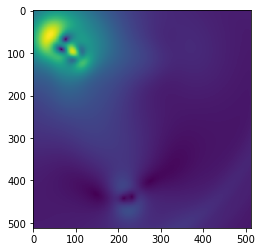

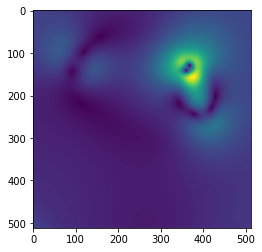

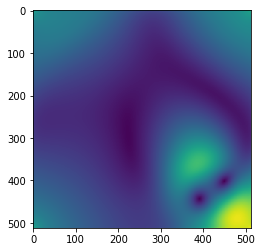

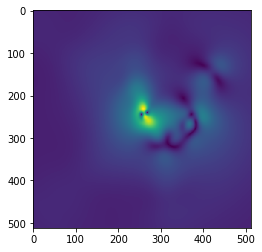

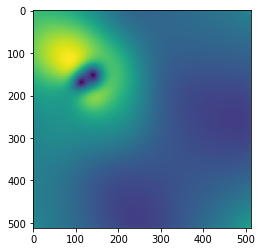

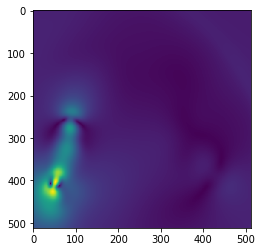

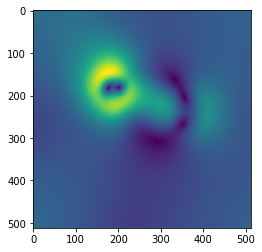

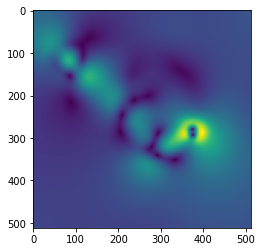

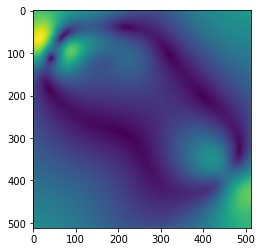

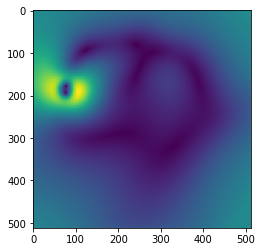

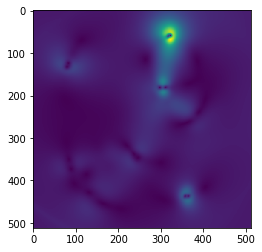

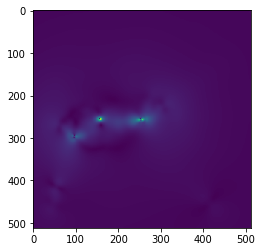

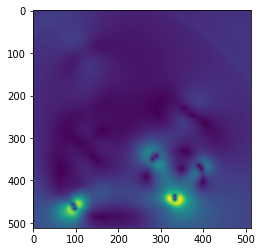

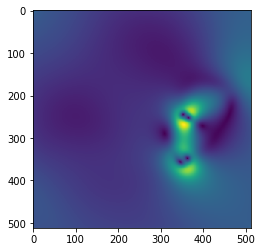

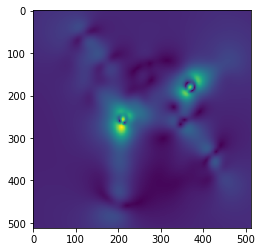

In [9]:
main_create_raytraced_grid_maps()

0

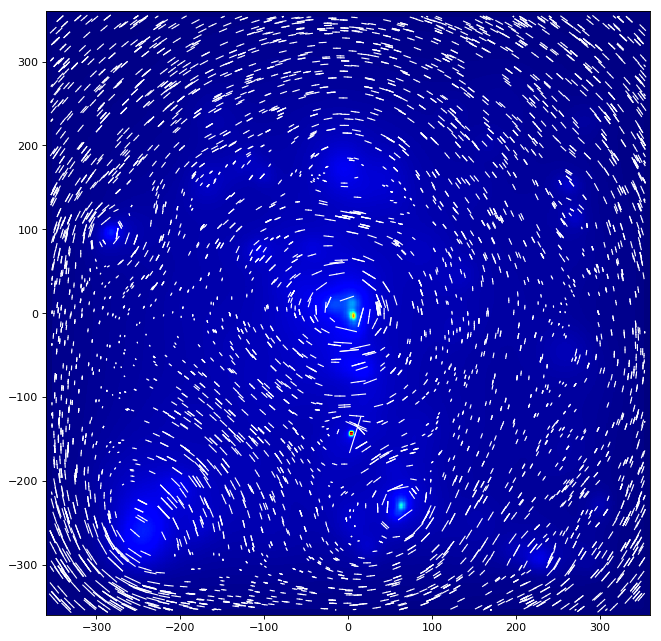

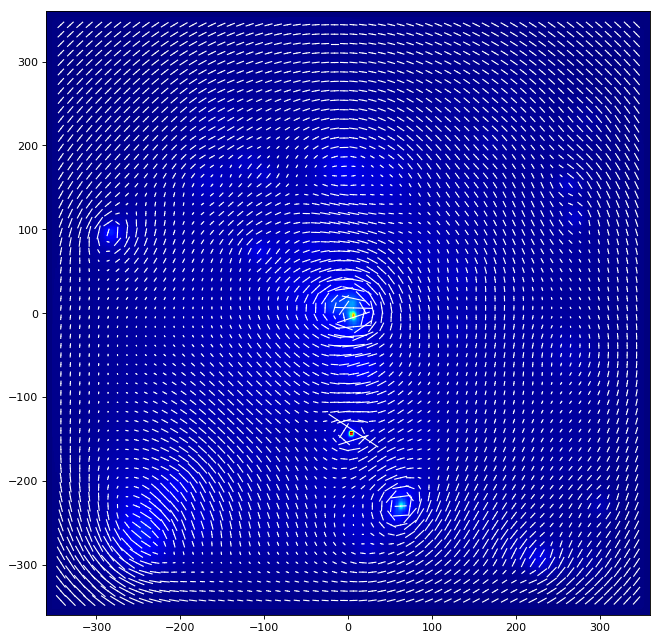

In [10]:
main_make_mocks(1.5)